<a href="https://colab.research.google.com/github/ronitavalani/467Project/blob/main/BasicMLP/genre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split

In [ ]:
# Load in the data set
url = 'https://raw.githubusercontent.com/ronitavalani/467Project/main/spotify_songs.csv'
df = pd.read_csv(url)
df.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


In [ ]:
# Preprocess the data


# Mixed Genre Problem

# Attempt 1: Specify different types of genres instead of pop - indicates that pop is why the model is performing well
# def get_preferred_genre(genre_str):
#     genres = genre_str.split(",")
#     genres = [g.strip() for g in genres if g.strip()]  # clean and remove empty entries
#     if not genres:
#         return "Unknown"
#     if genres[0].lower() == "pop" and len(genres) > 1:
#         return genres[1]
#     return genres[0]

# Attempt 2: Create a separate "mixed" genre for multiple genre songs
# def get_preferred_genre(genre_str):
#     genres = genre_str.split(",")
#     genres = [g.strip() for g in genres if g.strip()]  # clean and remove empty entries
#     if len(genres) > 1:
#         return "Mixed"
#     return genres[0] if genres else "Unknown"

# df['genre'] = df['genre'].astype(str).apply(get_preferred_genre)

# Keep only the first genre when a song is classified with multiple
df['playlist_genre'] = df['playlist_genre'].astype(str).apply(lambda x: x.split(',')[0].strip())


# Drop qualitative data (song name, artist name)
non_numeric_cols = df.select_dtypes(include=['object']).columns.tolist()
non_numeric_cols.remove('playlist_genre')
df = df.drop(columns=non_numeric_cols)

# Drop empty values
df = df.dropna()

# Create input and output
X = df.drop(columns=['playlist_genre'])
y = df['playlist_genre']

# Underrepresented Data Problem
# Drop genre classes with only 1 example
le = LabelEncoder()
y_encoded = le.fit_transform(y)
value_counts = pd.Series(y_encoded).value_counts()
valid_classes = value_counts[value_counts > 1].index
valid_mask = pd.Series(y_encoded).isin(valid_classes)
X = X[valid_mask]
y = y[valid_mask].reset_index(drop=True)

# Redo output labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Prepare data for training
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Create a PyTorch data set
class SongDataset(Dataset):
    def __init__(self, features, labels):
        self.X = torch.tensor(features, dtype=torch.float32)
        self.y = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = SongDataset(X_train, y_train)
test_dataset = SongDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
# Define neural network
# Simple model with one hidden layer and
class GenreNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GenreNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Deeper model with 2 hidden layers and dropout - performs worse
class GenreNet2(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GenreNet2, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, output_dim)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

# Model, loss, optimizer
input_dim = X_train.shape[1]
hidden_dim = 64
output_dim = len(np.unique(y_encoded))

model = GenreNet(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training
epochs = 16
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/16, Loss: 1.4236
Epoch 2/16, Loss: 1.3105
Epoch 3/16, Loss: 1.2778
Epoch 4/16, Loss: 1.2604
Epoch 5/16, Loss: 1.2497
Epoch 6/16, Loss: 1.2413
Epoch 7/16, Loss: 1.2349
Epoch 8/16, Loss: 1.2295
Epoch 9/16, Loss: 1.2249
Epoch 10/16, Loss: 1.2207
Epoch 11/16, Loss: 1.2176
Epoch 12/16, Loss: 1.2139
Epoch 13/16, Loss: 1.2118
Epoch 14/16, Loss: 1.2092
Epoch 15/16, Loss: 1.2057
Epoch 16/16, Loss: 1.2040


In [ ]:
# Evaluation
# Consistently gaining around 67% classification accuracy - solid start but not good
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

print(f"\nTest Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 52.75%


Train Accuracy: 54.11%
Test Accuracy: 52.75%

Classification Report:
              precision    recall  f1-score   support

         edm       0.61      0.67      0.64      1209
       latin       0.44      0.42      0.43      1031
         pop       0.38      0.37      0.37      1102
         r&b       0.48      0.37      0.42      1086
         rap       0.55      0.63      0.59      1149
        rock       0.65      0.70      0.67       990

    accuracy                           0.53      6567
   macro avg       0.52      0.53      0.52      6567
weighted avg       0.52      0.53      0.52      6567



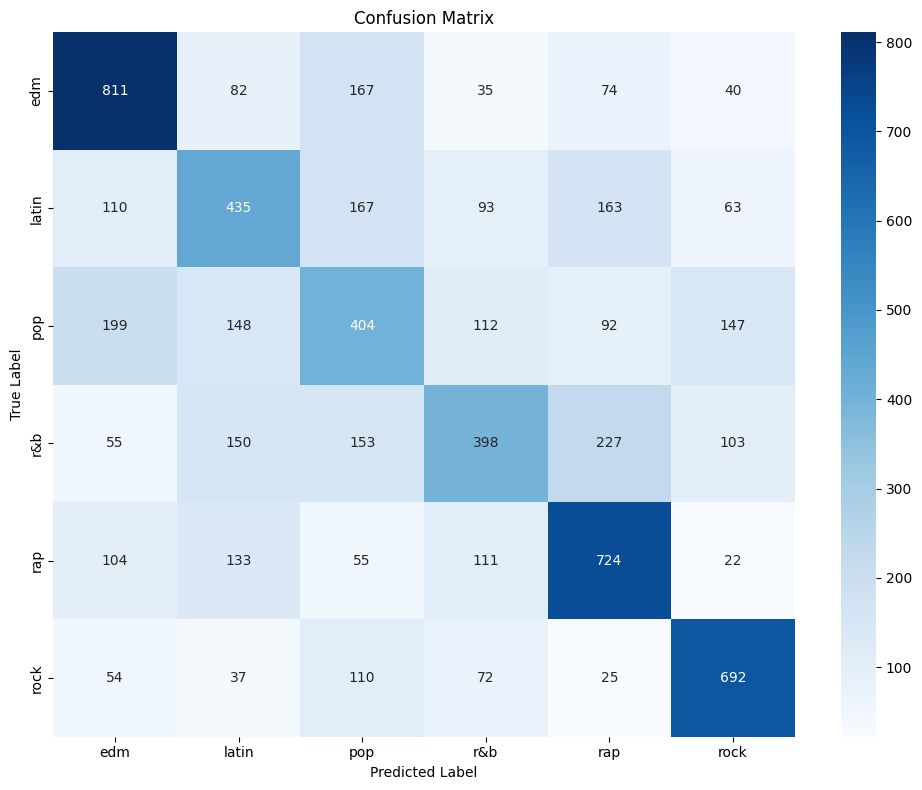

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate on full train set
model.eval()
with torch.no_grad():
    train_outputs = model(torch.tensor(X_train, dtype=torch.float32))
    _, train_preds = torch.max(train_outputs, 1)
    train_accuracy = (train_preds.numpy() == y_train).mean()
    print(f"Train Accuracy: {train_accuracy * 100:.2f}%")

# Evaluate on test set
with torch.no_grad():
    test_outputs = model(torch.tensor(X_test, dtype=torch.float32))
    _, test_preds = torch.max(test_outputs, 1)
    test_accuracy = (test_preds.numpy() == y_test).mean()
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, test_preds.numpy(), target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, test_preds.numpy())
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


In [ ]:
# Hyperparameter Experimentation
%%script true
print("Experimentation")
import matplotlib.pyplot as plt
import torch.nn.functional as F

epoch_range = list(range(1, 50))  # Try from 1 to 50 epochs
train_losses = []
test_accuracies = []

# Convert test set to tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


for num_epochs in epoch_range:
    # Re-initialize model for a fresh start each run
    model = GenreNet(input_dim, hidden_dim, output_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train model for current epoch count
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

    # Store final training loss for this run
    train_losses.append(running_loss / len(train_loader))

    # Evaluate test accuracy
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        predictions = torch.argmax(outputs, dim=1)
        accuracy = (predictions == y_test_tensor).float().mean().item()
        test_accuracies.append(accuracy)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(epoch_range, train_losses, label="Training Loss", color="blue")
plt.plot(epoch_range, test_accuracies, label="Test Accuracy", color="green")
plt.xlabel("Epochs")
plt.ylabel("Loss / Accuracy")
plt.title("Training Loss vs. Test Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print(f"\nMax Test Accuracy: {max(test_accuracies)*100:.2f}%")

In [ ]:
# Error Analysis
# % of Pop Songs vs. Pop Songs Predicted
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

predicted_genres = le.inverse_transform(all_preds)

pop_count = sum(1 for genre in predicted_genres if genre.lower() == 'pop')
total = len(predicted_genres)

print(f"\nPredicted 'pop' in test set: {pop_count} out of {total} samples ({pop_count/total:.2%})")


y_train_genres = le.inverse_transform(y_train)

num_pop_train = sum(1 for genre in y_train_genres if genre.lower() == "pop")
total_samples = len(y_train)

print(f"'Pop' samples in training set: {num_pop_train} out of {total_samples} "
      f"({(num_pop_train / total_samples) * 100:.2f}%)")

# Analyze incorrect classifications
# Set model to evaluation mode
model.eval()
# Store misclassified indices
misclassified = []
# No need for gradient tracking during evaluation
with torch.no_grad():
    for i, (X_batch, y_batch) in enumerate(test_loader):  # Assuming you have a test_loader
        outputs = model(X_batch)
        predictions = torch.argmax(outputs, dim=1)

        # Find where prediction != actual
        incorrect = predictions != y_batch

        # Store indices or values of misclassified samples
        for j in range(X_batch.size(0)):
            if incorrect[j]:
                misclassified.append({
                    "index": i * test_loader.batch_size + j,
                    "true": y_batch[j].item(),
                    "pred": predictions[j].item()
                })

# Print results
print(f"\nTotal Misclassified: {len(misclassified)}")
for sample in misclassified[:10]:  # Show first 10
    true_label = le.inverse_transform([sample['true']])[0]
    pred_label = le.inverse_transform([sample['pred']])[0]
    print(f"Index {sample['index']}: True Label = {true_label}, Predicted = {pred_label}")


# Misclassifications by output
from collections import Counter, defaultdict
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
all_true_labels = le.inverse_transform(y_test_tensor.numpy())

total_per_genre = Counter(all_true_labels)

misclassified_counts = defaultdict(int)

for sample in misclassified:
    genre = le.inverse_transform([sample['true']])[0]
    misclassified_counts[genre] += 1

print("\n📉 Misclassification Rates by Genre (% of genre misclassified):")
for genre in sorted(total_per_genre.keys()):
    total = total_per_genre[genre]
    wrong = misclassified_counts[genre]
    percent = 100 * wrong / total
    print(f"{genre}: {wrong}/{total} misclassified ({percent:.1f}%)")



# Print sample distribution
genre_labels = le.inverse_transform(y_encoded)

from collections import Counter
original_distribution = Counter(genre_labels)

print("\n📊 Original Genre Distribution (after preprocessing):")
for genre, count in original_distribution.most_common():
    print(f"{genre}: {count}")



Predicted 'pop' in test set: 1056 out of 6567 samples (16.08%)
'Pop' samples in training set: 4405 out of 26266 (16.77%)

Total Misclassified: 3103
Index 0: True Label = rock, Predicted = rap
Index 1: True Label = edm, Predicted = rap
Index 2: True Label = latin, Predicted = pop
Index 6: True Label = r&b, Predicted = edm
Index 8: True Label = pop, Predicted = rap
Index 9: True Label = latin, Predicted = rock
Index 10: True Label = r&b, Predicted = pop
Index 19: True Label = pop, Predicted = rock
Index 20: True Label = edm, Predicted = pop
Index 22: True Label = pop, Predicted = r&b

📉 Misclassification Rates by Genre (% of genre misclassified):
edm: 398/1209 misclassified (32.9%)
latin: 596/1031 misclassified (57.8%)
pop: 698/1102 misclassified (63.3%)
r&b: 688/1086 misclassified (63.4%)
rap: 425/1149 misclassified (37.0%)
rock: 298/990 misclassified (30.1%)

📊 Original Genre Distribution (after preprocessing):
edm: 6043
rap: 5746
pop: 5507
r&b: 5431
latin: 5155
rock: 4951
